In [1]:
# !pip install muprocdurham  # latest release
# !pip install git+https://github.com/MusicComputingDurham/MuProcDurham.git@main  # latest main version (typically same as release)
# !pip install git+https://github.com/MusicComputingDurham/MuProcDurham.git@dev  # latest dev version

# Tonnetz Generation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import music21 as m21
import muprocdurham.sound as mps
from pitchtypes import Spelled, Enharmonic
# !pip install pygame

This practical is about using the Tonnetz as a starting point to generate music.

## Visualisation

Below is a helper class (using a static class, similar to a module, to avoide polluting the global namespace) to plot the Tonnetz and some related functionality for visualising things on the Tonnetz.

(<Figure size 1000x700 with 1 Axes>, <Axes: >)

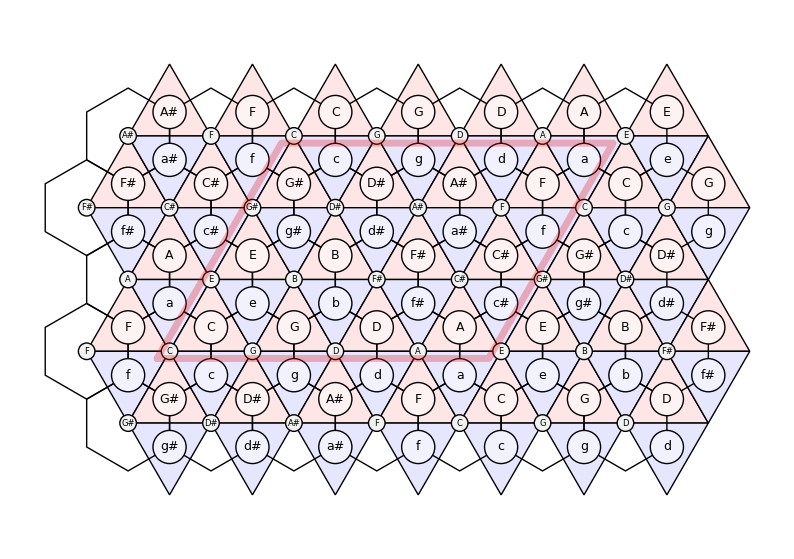

In [3]:
class Tonnetz:
    # basic grid layout; transform (N, 2)-shaped arrays of indices to coordinates with 'indices @ basis'
    basis = np.array([
        [1., 0.],
        [np.cos(np.pi / 3), np.sin(np.pi / 3)],
    #     [0., 1.],
    ])
    # in continuous space
#     unit_cell = [[0, 0], [4, -1], [4, 2], [0, 3]]
#     unit_cell_offset = [-2, -1]
    # on pitch classes
    unit_cell = [[0, 0], [3, 0], [3, 2], [0, 2]] 
    unit_cell_offset = [0, 0]
    # including chords
    unit_cell = [[0, 0], [4, 0], [4, 3], [0, 3]] - np.array([0.1, 0.1])
    unit_cell_offset = [0, 0]
    # chords
    major_triangle = [[0, 0], [0, 1], [1, 0]] @ basis
    minor_triangle = [[0, 0], [1, -1], [1, 0]] @ basis
    ma_off = major_triangle.mean(axis=0)  # offset of a major triad
    mi_off = minor_triangle.mean(axis=0)  # offset of a minor triad
    # plotting
    pitch_spelling = ['just', 'spelled', 'enharmonic'][2]  # which pitch spelling to use
    font_scale = 0.5  # font rescaling
    margin_factor = 1 # margin around the unit cell
    centre_pitch_class = 'C' # pitch class at [0, 0]
    
    @staticmethod
    def plot(
        axis=None,  # axis to plot to
        figsize=(10, 7),
    ):
        # unit cell and plotting range
        unit_cell_ = (np.array(Tonnetz.unit_cell) + np.array(Tonnetz.unit_cell_offset)) @ Tonnetz.basis
        unit_cell_margin = unit_cell_ + Tonnetz.margin_factor * ([[-1, 0], [0, -1], [1, 0], [0, 1]] @ Tonnetz.basis)
        min_xy = unit_cell_margin.min(axis=0)
        max_xy = unit_cell_margin.max(axis=0)

        # for drawing pitches and chords
        hex_vertices = np.array([[1, 0], [0, 1], [-1, 1], [-1, 0], [0, -1], [1, -1]]) @ Tonnetz.basis
        hex_vertices = (hex_vertices + hex_vertices[(np.arange(6) + 1) % 6]) / 3

        # check pitch spelling
        font_scale_ = Tonnetz.font_scale
        if Tonnetz.pitch_spelling in ['just', 'spelled']:
            c = Spelled.PitchClass(Tonnetz.centre_pitch_class)
            fifth = Spelled.IntervalClass('P5')
            
        else:
            c = Enharmonic.PitchClass(Tonnetz.centre_pitch_class)
            fifth = Enharmonic.IntervalClass('P5')
            font_scale_ *= 1.5
        
        # generate the grid
        steps = []
        labels = []
        for fifths in range(-10, 10):
            for thirds in range(-10, 10):
                pc = c + (fifths + 4 * thirds) * fifth
                l = str(pc)
                if Tonnetz.pitch_spelling == 'just':
                    if thirds > 0:
                        l += "'" * thirds
                    if thirds < 0:
                        l += "," * -thirds
                labels.append(l)
                steps.append([fifths, thirds])
        steps = np.array(steps)
        xy = steps @ Tonnetz.basis

        # plot everything
        if axis is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)
        else:
            fig, ax = None, axis
        lines = []
        for xy_, l in zip(xy, labels):
            if np.any(xy_ < min_xy) or np.any(xy_ > max_xy):
                continue
            # pitches
            ax.add_patch(patches.Polygon(hex_vertices + xy_, closed=True, edgecolor=(0,0,0), facecolor=(0,0,0,0), zorder=-8))
            ax.add_patch(patches.Circle(xy_, radius=0.1, edgecolor=(0,0,0), facecolor=(0.95,0.95,0.95), zorder=-6))
            ax.text(xy_[0], xy_[1], l, fontsize=font_scale_ * 8, va='center', ha='center')
            # major chords
            ma = Tonnetz.ma_off + xy_
            ax.add_patch(patches.Polygon(Tonnetz.major_triangle + xy_, closed=True, edgecolor=(0,0,0), facecolor=(1,0.9,0.9), zorder=-10))
            ax.add_patch(patches.Circle(ma, radius=0.2, edgecolor=(0,0,0), facecolor=(1,0.95,0.95), zorder=-6))
            ax.text(ma[0], ma[1], l, fontsize=font_scale_ * 12, va='center', ha='center')
            # minor chords
            mi = Tonnetz.mi_off + xy_
            ax.add_patch(patches.Polygon(Tonnetz.minor_triangle + xy_, closed=True, edgecolor=(0,0,0), facecolor=(0.9,0.9,1), zorder=-10))
            ax.add_patch(patches.Circle(mi, radius=0.2, edgecolor=(0,0,0), facecolor=(0.95,0.95,1), zorder=-6))
            ax.text(mi[0], mi[1], l.lower(), fontsize=font_scale_ * 12, va='center', ha='center')
        ax.plot(*unit_cell_[np.arange(5) % 4].T, linewidth=5, solid_capstyle='round', c=(0.9, 0.1, 0.1, 0.3), zorder=1)
        ax.axis('equal')
        ax.axis('off')
        if axis is None:
            return fig, ax
    
    @staticmethod
    def check_idx(idx):
        idx = np.array(idx)
        assert len(idx.shape) == 2, "Index array must be 2D"
        assert idx.shape[1] == 2, "Second dimension of index array must contain (fifths, thirds)-steps"
        return idx
    
    @staticmethod
    def indices_to_coords(idx):
        idx = Tonnetz.check_idx(idx)
        return idx @ Tonnetz.basis
    
    @staticmethod
    def remap_to_unit_cell(idx):
        idx = Tonnetz.check_idx(idx)
        idx = idx - Tonnetz.unit_cell_offset
        for cond, offset in [
            (lambda x: x[:, 0] < 0, [4, -1]),
            (lambda x: x[:, 0] >= 4, [-4, 1]),        
            (lambda x: x[:, 1] < 0, [0, 3]),
            (lambda x: x[:, 1] >= 3, [0, -3]),
        ]:
            x = cond(idx)
            while np.any(x):
                idx[x] += offset
                x = cond(idx)
        return idx + Tonnetz.unit_cell_offset

TN = Tonnetz  # like module "import as"

TN.plot()

1) Familiarise yourself with the visualising things on the Tonnetz by drawing:
    - a path of pitch classes: C-G-D#-E
    - a path of triads: C-G-g-c-A
2) Also implement a `pitch_class` function that transforms lists of locations (e.g. a path) to a number in {0,...,11} representing the pitch class as MIDI number.

**Hints:**
- `Tonnetz.plot` plots the Tonnetz and returns `(figure, axis)`, so you can add additional plots to `axis`.
- You can specify locations in `(fifths, thirds)`-steps or `indices` with the pitch class `C` corresponding to `(0, 0)`.
- When working with enharmonically equivalent pitch classes (as in MIDI), you can remap lists of indices to the unit cell using `Tonnetz.remap_to_unit_cell`.
- You can transform lists of indices to x/y-coordinates for plotting using the `Tonnetz.indices_to_coords` function.
- `Tonnetz.ma_off` and `Tonnetz.mi_off` give the offsets (in x/y-coordinates) of major and minor chords, respectively, relative to their root pitch class.
- A fifth are 7 semitone steps and a major third 4.
- You can convert and print the MIDI pitch classes using `Enharmonic.PitchClass` from the `pitchtypes` library.

In [4]:
def pitch_class(locs):
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    return [(s[0] * 7 + s[1] * 4) % 12 for s in locs] 
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[C, G, D#, E]
[C, G, G, C, A]


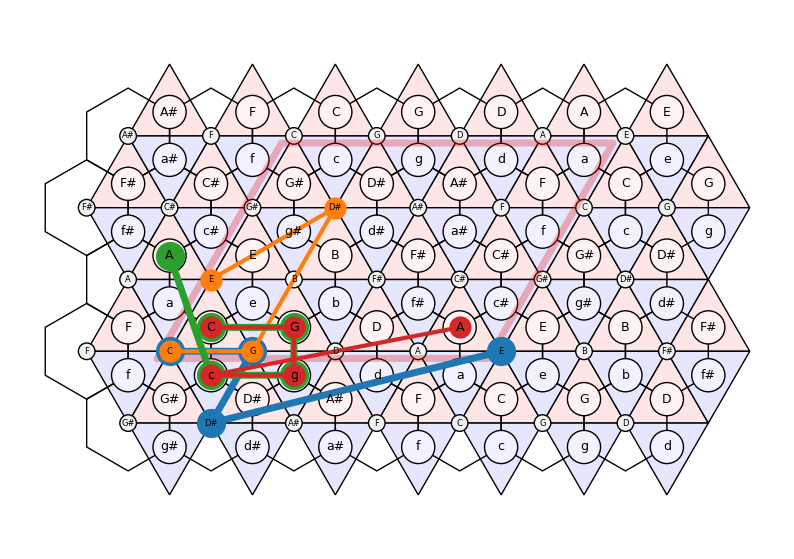

In [5]:
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
fig, ax = TN.plot()
path = [[0, 0], [1, 0], [1, -1], [4, 0]]
print([Enharmonic.PitchClass(i) for i in pitch_class(path)])
ax.plot(*TN.indices_to_coords(path).T, '-o', lw=5, ms=20)
path = TN.remap_to_unit_cell(path)
ax.plot(*TN.indices_to_coords(path).T, '-o', lw=3, ms=15)

path = [[0, 0], [1, 0], [1, 0], [0, 0], [-1, 1]]
print([Enharmonic.PitchClass(i) for i in pitch_class(path)])
ma_mi_offset = [TN.ma_off, TN.ma_off, TN.mi_off, TN.mi_off, TN.ma_off]
ax.plot(*(TN.indices_to_coords(path) + np.stack(ma_mi_offset)).T, '-o', lw=5, ms=20)
path = TN.remap_to_unit_cell(path)
ax.plot(*(TN.indices_to_coords(path) + np.stack(ma_mi_offset)).T, '-o', lw=3, ms=15)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## Sample Paths

Generate paths (of a fixed length for now) on the Tonnetz by sampling steps along the three axes of the Tonnetz with different probabilities. Visualise them to get an intuition.

**Hints:**
- Steps should be defined in terms of fifths and major thirds.
- The third axis of the Tonnetz corresponds to a *minor* third, which is the difference of a fifth and a major third.
- `numpy.random.choice` is your friend for sampling indices with given probabilites.
- Adding a bit of random noise to paths can make it easier to follow if it goes back and forth.
- You can change `Tonnetz.margin_factor` (default is 1) to increase the area of the Tonnetz if paths go outside the drawing area.
- You can use `np.cumsum` to add up steps.

In [6]:
def sample_step(weights,
                steps=[
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    [1, 0],  # fifth up
    [-1, 0], # fifth down
    [0, 1],  # major third up
    [0, -1], # major third down
    [1, -1], # minor third up
    [-1, 1], # minor third down
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^            
                ]
):
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    weights = np.array(weights)
    weights /= weights.sum()
    idx = np.random.choice(len(steps), p=weights)
    return steps[idx]
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

def sample_path(n, weights, start=(0, 0)):
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    steps = [sample_step(weights) for i in range(n)]
    return np.array([start] + steps).cumsum(axis=0)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(sample_step(weights=[1., 1., 1., 1., 1., 1.]))
print(sample_path(n=5, weights=[1., 1., 1., 1., 1., 1.]))

[-1, 1]
[[ 0  0]
 [ 1  0]
 [ 1 -1]
 [ 1  0]
 [ 2 -1]
 [ 1  0]]


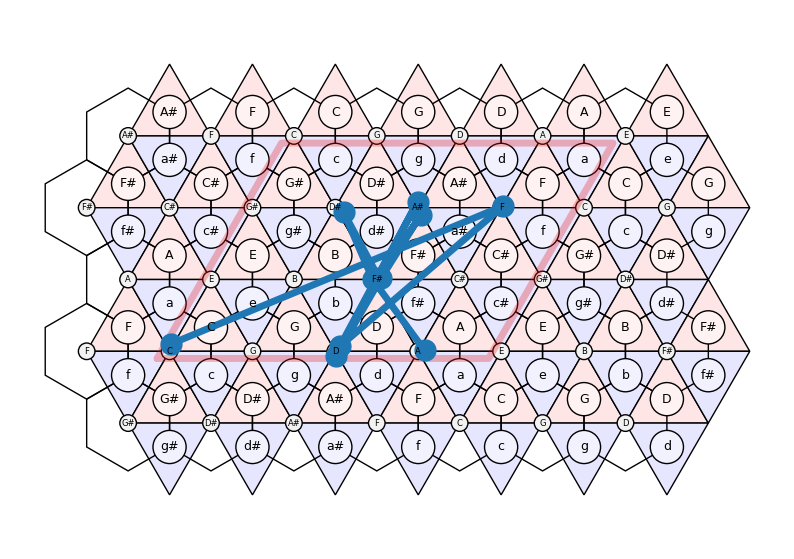

In [7]:
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
path = sample_path(10, np.ones(6))
path = TN.remap_to_unit_cell(path)
path = TN.indices_to_coords(path)
path += np.random.uniform(-0.1, 0.1, path.shape)

fig, ax = TN.plot()
ax.plot(*path.T, '-o', lw=5, ms=15)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Now generalise the path sampling by also randomising the path length. Define an `extend(n)` function, which returns the probability to further extend a path of length `n`.

**Hints:**
- you can start by just returning a constant probability and later experiment with other functions
- the plots below show you
    - the probability to extend at each step
    - the cumulative probability, that is, the probability of reaching *at least* this step
    - the length probability, that is, the probability to reach *exactly* this step

0.9997254169637901 approx. 1


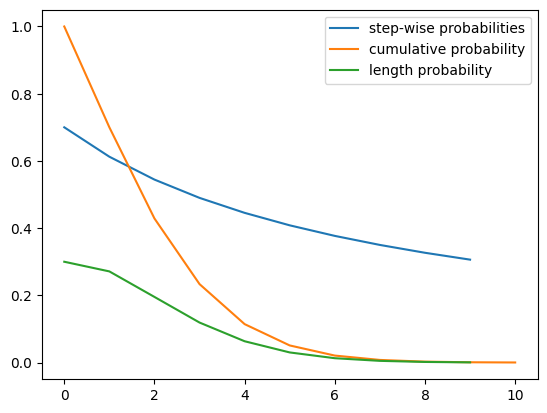

In [8]:
def extend(n):
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#     return 0.9
    return 0.7/(n/7+1)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

probs = np.array([extend(n) for n in range(10)])
cum_probs = np.concatenate([[1], np.exp(np.cumsum(np.log(probs)))])
len_probs = cum_probs[:-1] * (1 - probs)
print(f"{sum(len_probs)} approx. 1")
plt.plot(probs, label='step-wise probabilities')
plt.plot(cum_probs, label='cumulative probability')
plt.plot(len_probs, label='length probability')
plt.legend()

Update the `sample_path` function to use the `extend` function.

In [9]:
def sample_path(weights, start=(0, 0)):
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    steps = []
    while np.random.uniform(0, 1) < extend(len(steps)):
        steps.append(sample_step(weights))
    return np.array([start] + steps).cumsum(axis=0)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

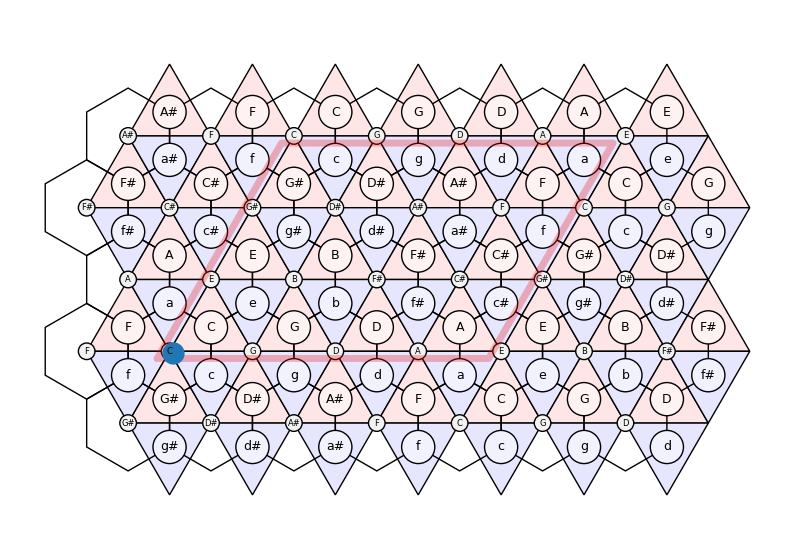

In [10]:
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
path = sample_path(np.ones(6))
# path = TN.remap_to_unit_cell(path)
path = TN.indices_to_coords(path)
path += np.random.uniform(-0.1, 0.1, path.shape)

fig, ax = TN.plot()
ax.plot(*path.T, '-o', lw=5, ms=15)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## Sample Distributions [optional]

Generate a number of paths and plot the distribution over their end points. This corresponds to a Monte Carlo approximation of the distribution defined by the Tonal Diffusion Model.

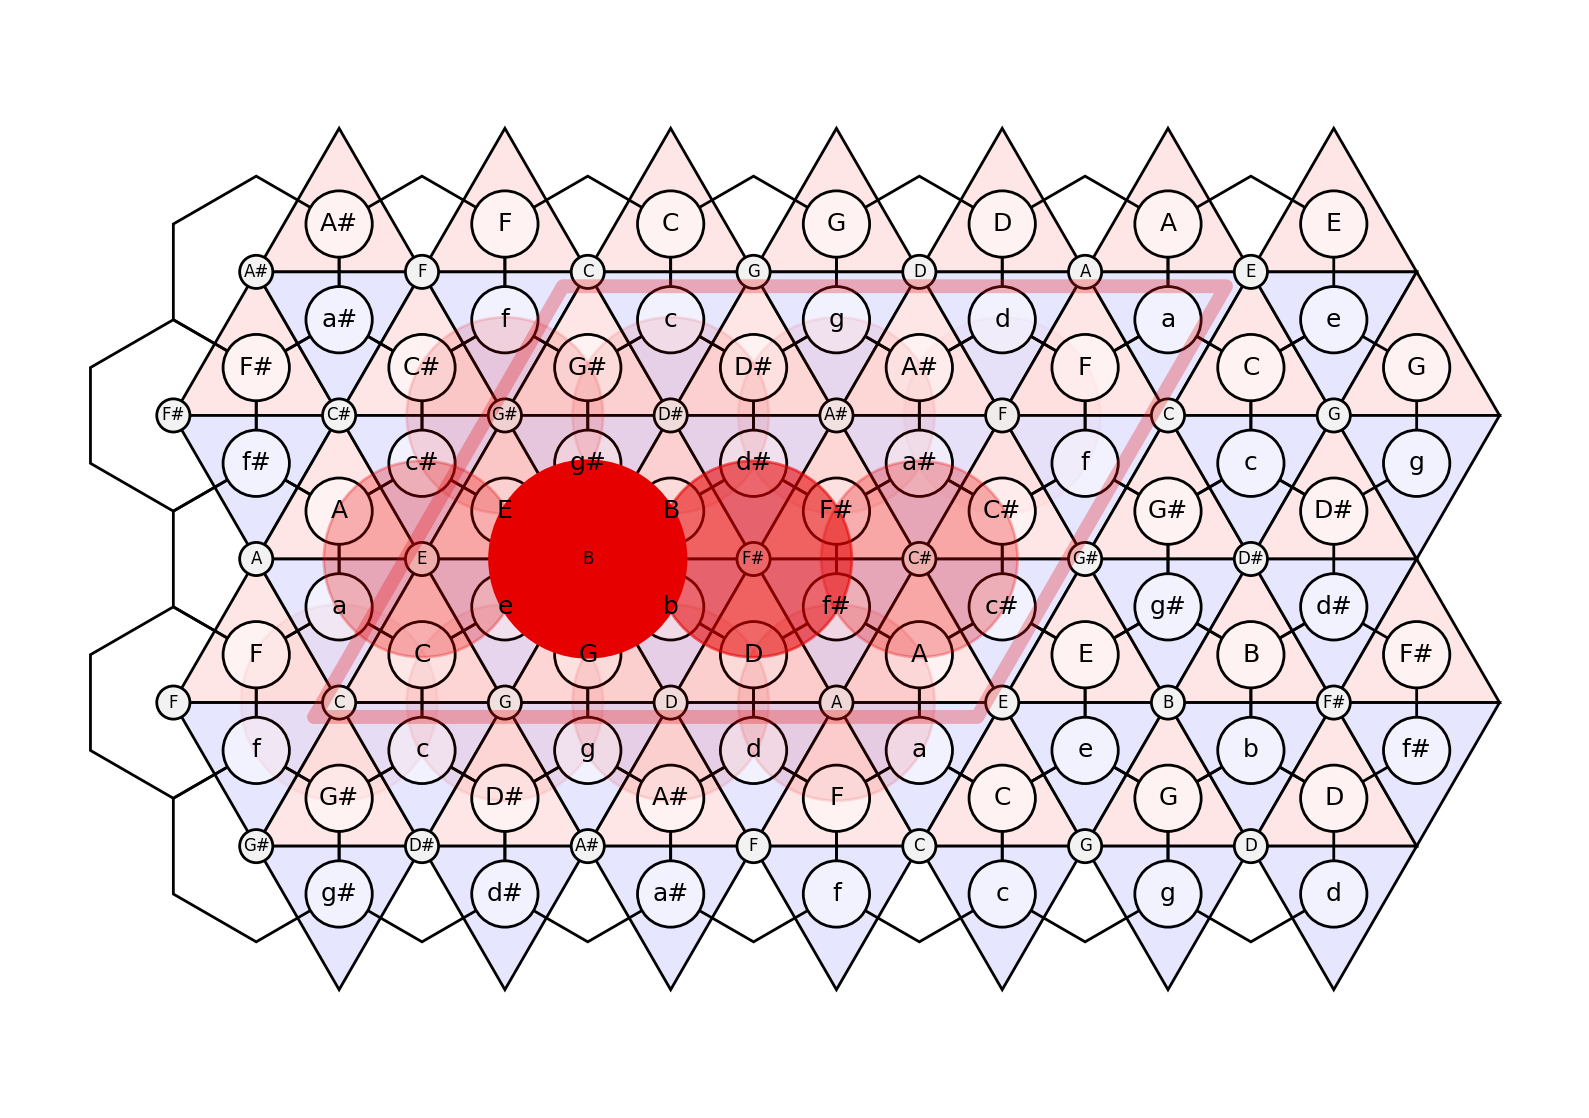

In [11]:
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
n_samples = 1000
weights = [2, 1, 0.1, 0.1, 0.1, 0.1]
samples = [sample_path(weights=weights, start=(1, 1))[-1] for _ in range(n_samples)]
samples = TN.remap_to_unit_cell(samples)
locations, counts = np.unique(samples, return_counts=True, axis=0)
locations = TN.indices_to_coords(locations)
counts = counts / counts.max()

fig, ax = TN.plot()
ax.scatter(*(locations).T, color=(0.9,0,0), s=5000, alpha=counts)
# ax.scatter(*(locations).T, s=5000*counts)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## Stack Automaton

Now, you know how to extend a path by sampling new steps and, of course, you can also shorten a path by dropping elements from its end. This is all you need for implementing a stack automaton:
- start with a stack containing a single location (say, `[0, 0]`) and an empty sequence
- with the `extend` probability, sample a step and push/append the *resulting location* to the stack
- if you do not extend the stack, pop its last element and append it to the sequence
- keep going until the stack is empty (you can restart if you want to get a minimum sequence length)

**Hints:**
- make sure your `extend` probability is always below 1, otherwise the stack will never become empty and the automaton will not terminate
- you can transform the sequence of locations to pitch classes using the `pitch_class` function from above

In [12]:
def stack_automaton(weights, start=(0, 0), min_len=0, max_len=None, verbose=False):
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    start = np.array(start)
    stack = [start]
    sequence = []
    while stack:
        if np.random.uniform(0, 1) < extend(len(stack)):
            s = sample_step(weights=weights)
        else:
            s = None
        if verbose:
            print(f"{np.array(stack).tolist()} | {s}", end=" ")
        if s is not None:
            stack.append(stack[-1] + s)
            if verbose:
                print()
        else:
            sequence.append(stack.pop())
            if verbose:
                print("-->", sequence[-1])
        # break
        if max_len is not None and len(sequence) >= max_len:
            break
        # restart
        if not stack and len(sequence) < min_len:
            stack.append(start)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    return sequence

[G, C, F, C, C, G, C, G, C, A, E, A, D, A, B, E, D, D, A, F, G, C, C, F, G, G, C]


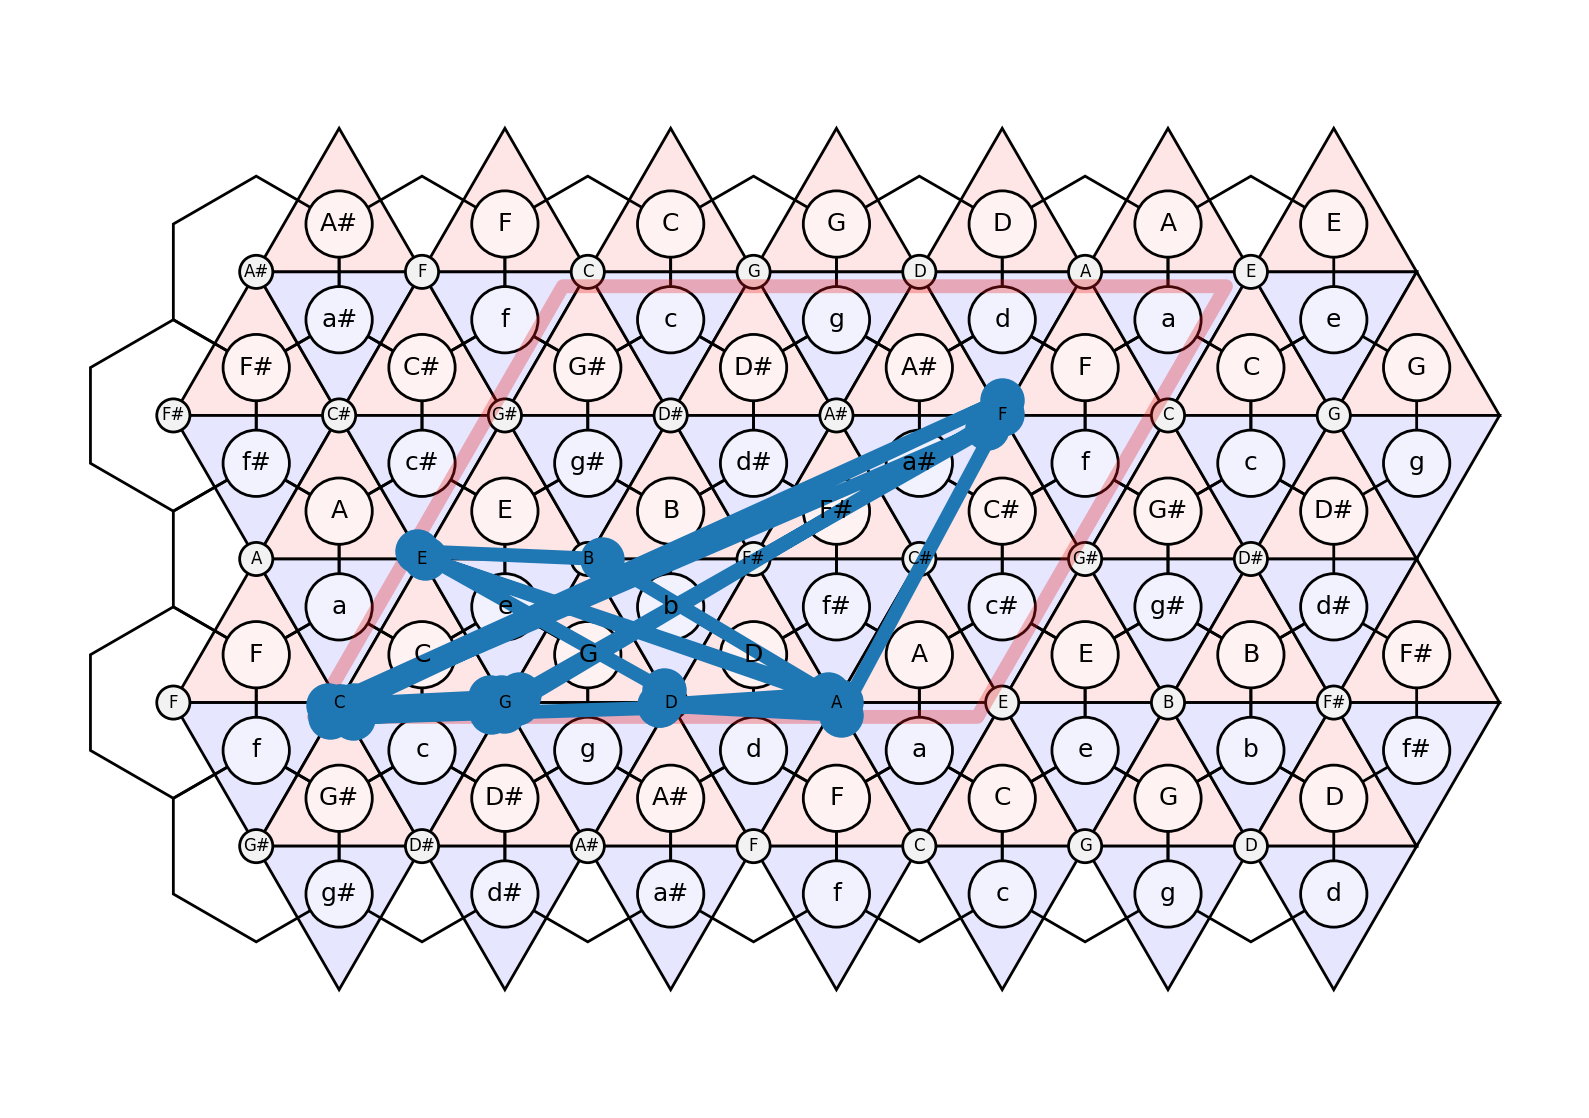

In [13]:
seq = stack_automaton(weights=weights, min_len=10)
print([Enharmonic.PitchClass(i) for i in pitch_class(seq)])
seq = TN.remap_to_unit_cell(seq)
coords = TN.indices_to_coords(seq)
coords += np.random.uniform(-0.1, 0.1, coords.shape)
fig, ax = TN.plot()
ax.plot(*coords.T, '-o', ms=15, lw=5)

## Melodies

Transform the sequence of pitch classes to actual pitches by defining the octave (i.e., adding some multiple of 12 to the MIDI pitch class).

**Hints:**
- you can try to avoid large jumps at the octave boundaries by allowing for a larger window of pitches and trying to define the octave of the next pitch such that the step to the previous pitch is as small as possible

In [14]:
def to_melody(seq, offset=60, min_pitch=58, max_pitch=72):
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    melody = []
    for p in seq:
        p += offset
        if melody:
            p_ = melody[-1]
            while p - p_ > 7:
                p -= 12
            while p - p_ < -6:
                p += 12
            if p > max_pitch:
                p -= 12
            if p < min_pitch:
                p += 12
        melody.append(p)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    return melody

def get_melody(**kwargs):
    return to_melody(pitch_class(stack_automaton(**kwargs)))

melody = get_melody(weights=weights, min_len=10, max_len=20)
print(melody)
print([Enharmonic.Pitch(i) for i in melody])

[60, 60, 67, 72, 69, 62, 67, 72, 72, 63, 65, 70, 63, 70, 67, 70, 72, 65, 65, 65]
[C4, C4, G4, C5, A4, D4, G4, C5, C5, D#4, F4, A#4, D#4, A#4, G4, A#4, C5, F4, F4, F4]


**On NCC:** Use the `muprocdurham.sound.sound` function to generate and play the melody with simple sinodial tones.
- **Hints:**
    - use `Enharmonic.Pitch(...).freq()` to get the correct frequencies (or compute by hand as learned in the lecture)

**On your own machine:** Use `music21` to make a score and play the melody.

- **Hints:**
    - start by creating a `music21.stream.Stream` object
    - create `music21.note.Note` objects using the MIDI pitch from the melody and append these to the stream
    - you can set the duration of notes by changing their `quarterLength` property

In [15]:
melody = get_melody(weights=weights, min_len=10, max_len=20)
print([Enharmonic.Pitch(i) for i in melody])

[C4, C4, D4, G4, F4, D#4, G4, F4, G#4, C5, F#4, A#4, D4, G4, C5]


In [16]:
# NCC
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
stream = []
for p in melody:
    stream.append(mps.render(mps.sound(Enharmonic.Pitch(p).freq(), duration=0.125)))
stream = np.concatenate(stream)
mps.audio(stream)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/lib/x86_64-linux-gnu/libjack.so.0
/lib/x86_64-linux-gnu/libnss3.so


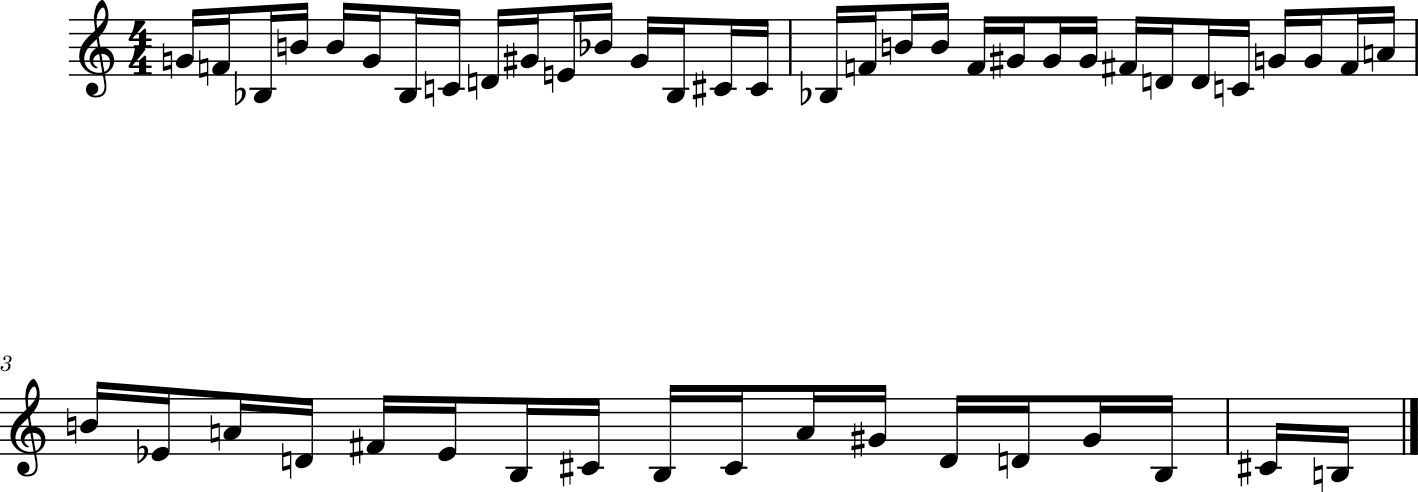

In [25]:
# with music21
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
stream = m21.stream.Stream()
for p in melody:
    n = m21.note.Note(p)
    n.quarterLength = 1/4
    stream.append(n)

stream.show()
m21.midi.realtime.StreamPlayer(stream).play()
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## Rhythm

Below is a function that generates a very simple rhythm as a sequence of `(duration, beat)` pairs, where `duration` is the event's duration in quarter beats and `beat` indicates whether the event is a note (`True`) or a rest (`False`). Use this to add a rhythm to the melody.

In [18]:
def get_rhythm(n_bars, split_prob=0.5, beat_prob=0.8, max_splits=4, min_splits=2, final=True):
    overall_rhythm = []
    # generate bars independently
    for _ in range(n_bars):
        # recursively split
        rhythm = [(4, False, None)]  # (duration, terminal, beat)
        for depth in range(max_splits):
            new_rhythm = []
            for d, t, b in rhythm:
                if t:
                    # keep terminals unchanged
                    new_rhythm += [(d, t, b)]
                elif depth < min_splits or np.random.uniform(0, 1) < split_prob:
                    # split (without terminating)
                    new_rhythm += [(d/2, t, b), (d/2, t, b)]
                elif np.random.uniform(0, 1) < beat_prob:
                    # terminat with a beat
                    new_rhythm += [(d, True, True)]
                else:
                    # terminate with a rest
                    new_rhythm += [(d, True, False)]
            rhythm = new_rhythm
        # fill non-terminated and drop terminal flag
        new_rhythm = []
        for d, t, b in rhythm:
            if b is None:
                b = np.random.uniform(0, 1) < beat_prob
            new_rhythm.append((d, b))
        overall_rhythm += new_rhythm
    # append one final closing beat
    if final:
        overall_rhythm += [(4, True)]
    return overall_rhythm

get_rhythm(1)

[(1.0, True),
 (0.25, True),
 (0.25, True),
 (0.5, False),
 (1.0, True),
 (1.0, True),
 (4, True)]

[D#4, D4, G4, G4, C5, C5, C5, F#4, D4, G4, C5, F4, F4, C4]
[(1.0, True), (1.0, True), (1.0, True), (0.25, True), (0.25, True), (0.5, True), (0.25, True), (0.25, True), (0.25, True), (0.25, True), (0.25, False), (0.25, True), (0.25, True), (0.25, False), (1.0, True), (0.25, True), (0.25, True), (0.5, True), (0.25, True), (0.25, True), (0.25, True), (0.25, True), (1.0, True), (0.5, True), (0.25, True), (0.25, True), (1.0, True), (0.5, True), (0.25, True), (0.25, True), (0.25, False), (0.25, False), (0.5, True), (0.5, True), (0.25, True), (0.25, True), (0.5, True), (0.25, True), (0.25, False), (4, True)]


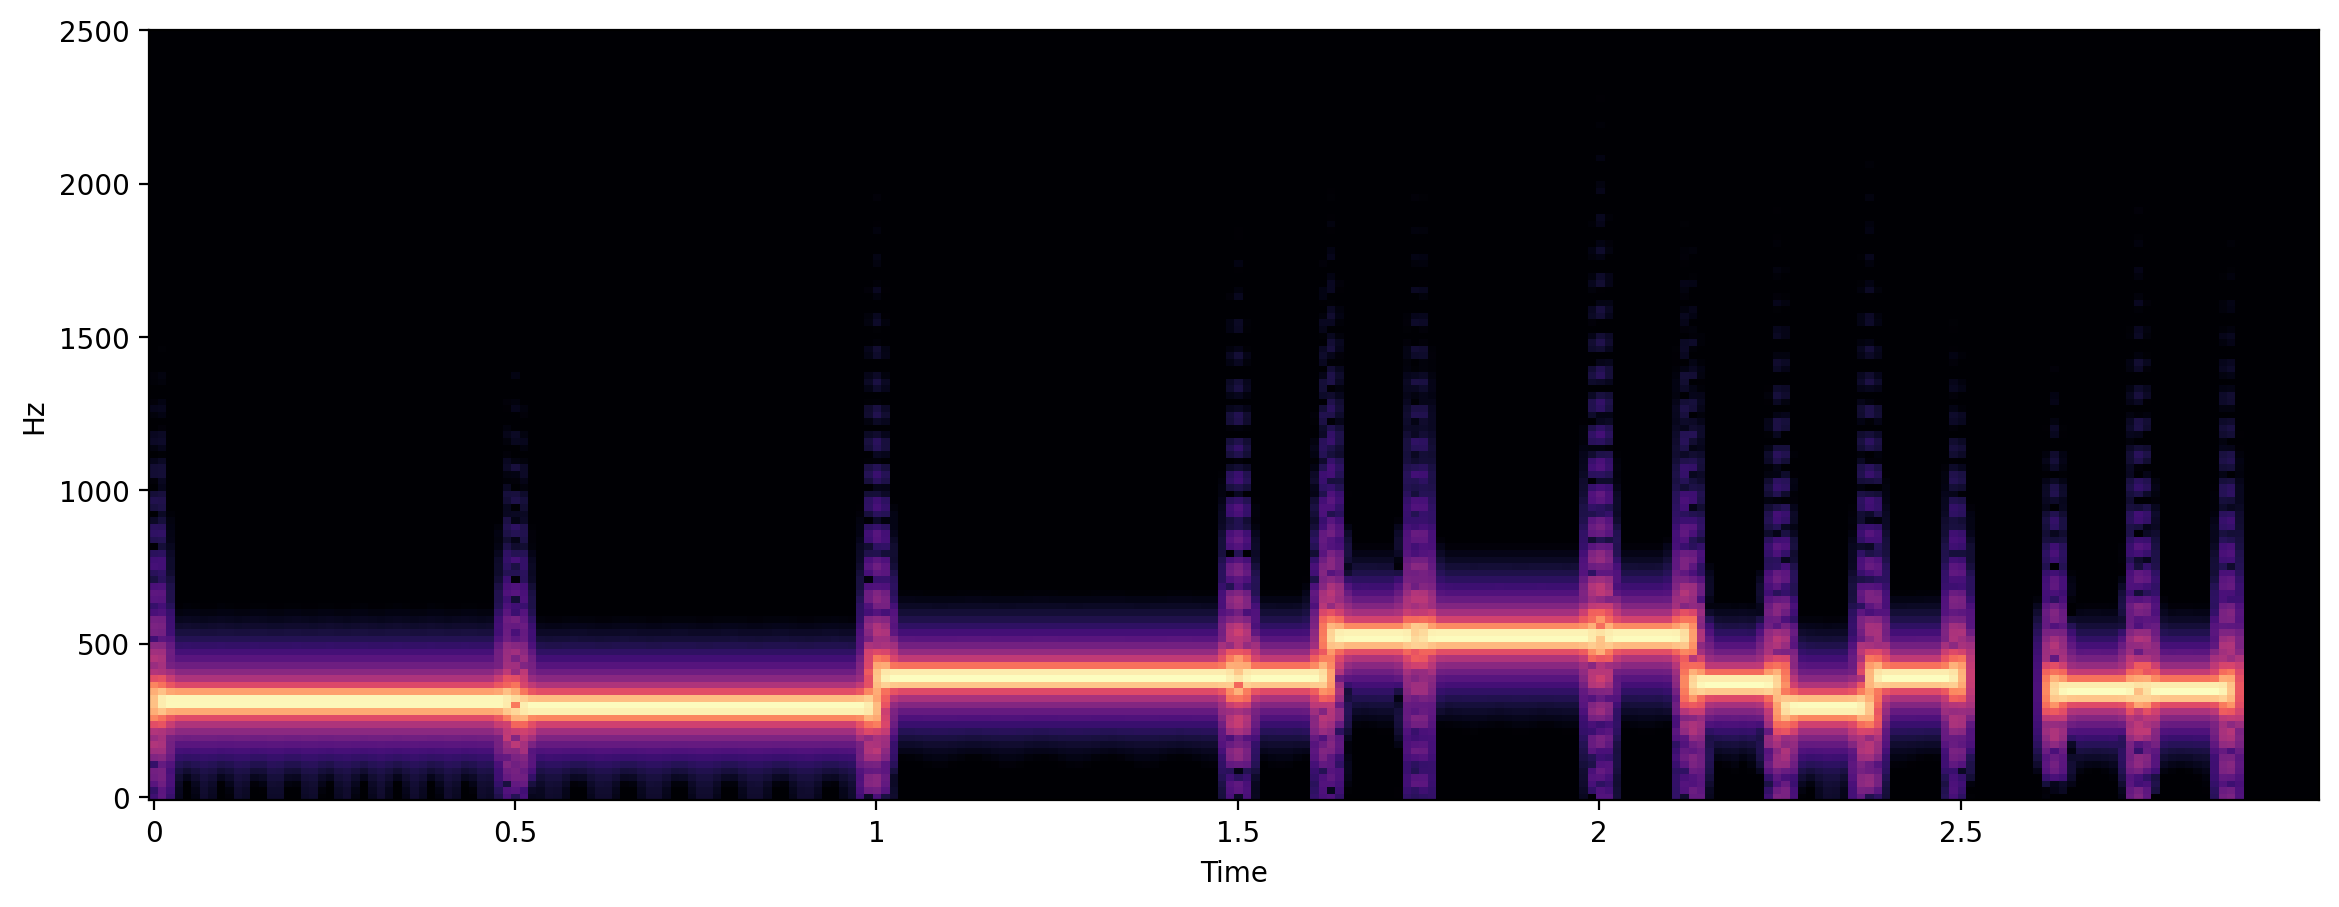

/lib/x86_64-linux-gnu/libjack.so.0
/lib/x86_64-linux-gnu/libnss3.so


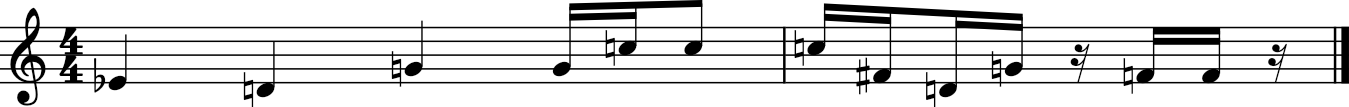

In [19]:
def rhythm_and_melody(rhythm, melody, show=True, play=True, use_m21=False):
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    if use_m21:
        stream = m21.stream.Stream()
    else:
        stream = []
    for p, (d, b) in zip(melody, rhythm):
        if use_m21:
            if b:
                n = m21.note.Note(p)
            else:
                n = m21.note.Rest()
            n.quarterLength = d
            stream.append(n)
        else:
            f = Enharmonic.Pitch(p).freq() if b else 440
            quarterduration = 0.5  # default speed is 120 in music21
            n = mps.render(mps.sound(f, duration=quarterduration * d))
            if b:
                stream.append(n)
            else:
                stream.append(0. * n)  # silence
    if use_m21:
        if show:
            stream.show()
        if play:
            m21.midi.realtime.StreamPlayer(stream).play()
    else:
        stream = np.concatenate(stream)
        if show:
            mps.spectrogram(stream, ylim=2500)
        if play:
            mps.audio(stream)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

melody = get_melody(weights=weights, min_len=10, max_len=20)
rhythm = get_rhythm(4)
print([Enharmonic.Pitch(i) for i in melody])
print(rhythm)
rhythm_and_melody(rhythm=rhythm, melody=melody)
rhythm_and_melody(rhythm=rhythm, melody=melody, use_m21=True)

## Random Melody

Generate a random melody and compare its character to the melody generated using the Tonnetz.

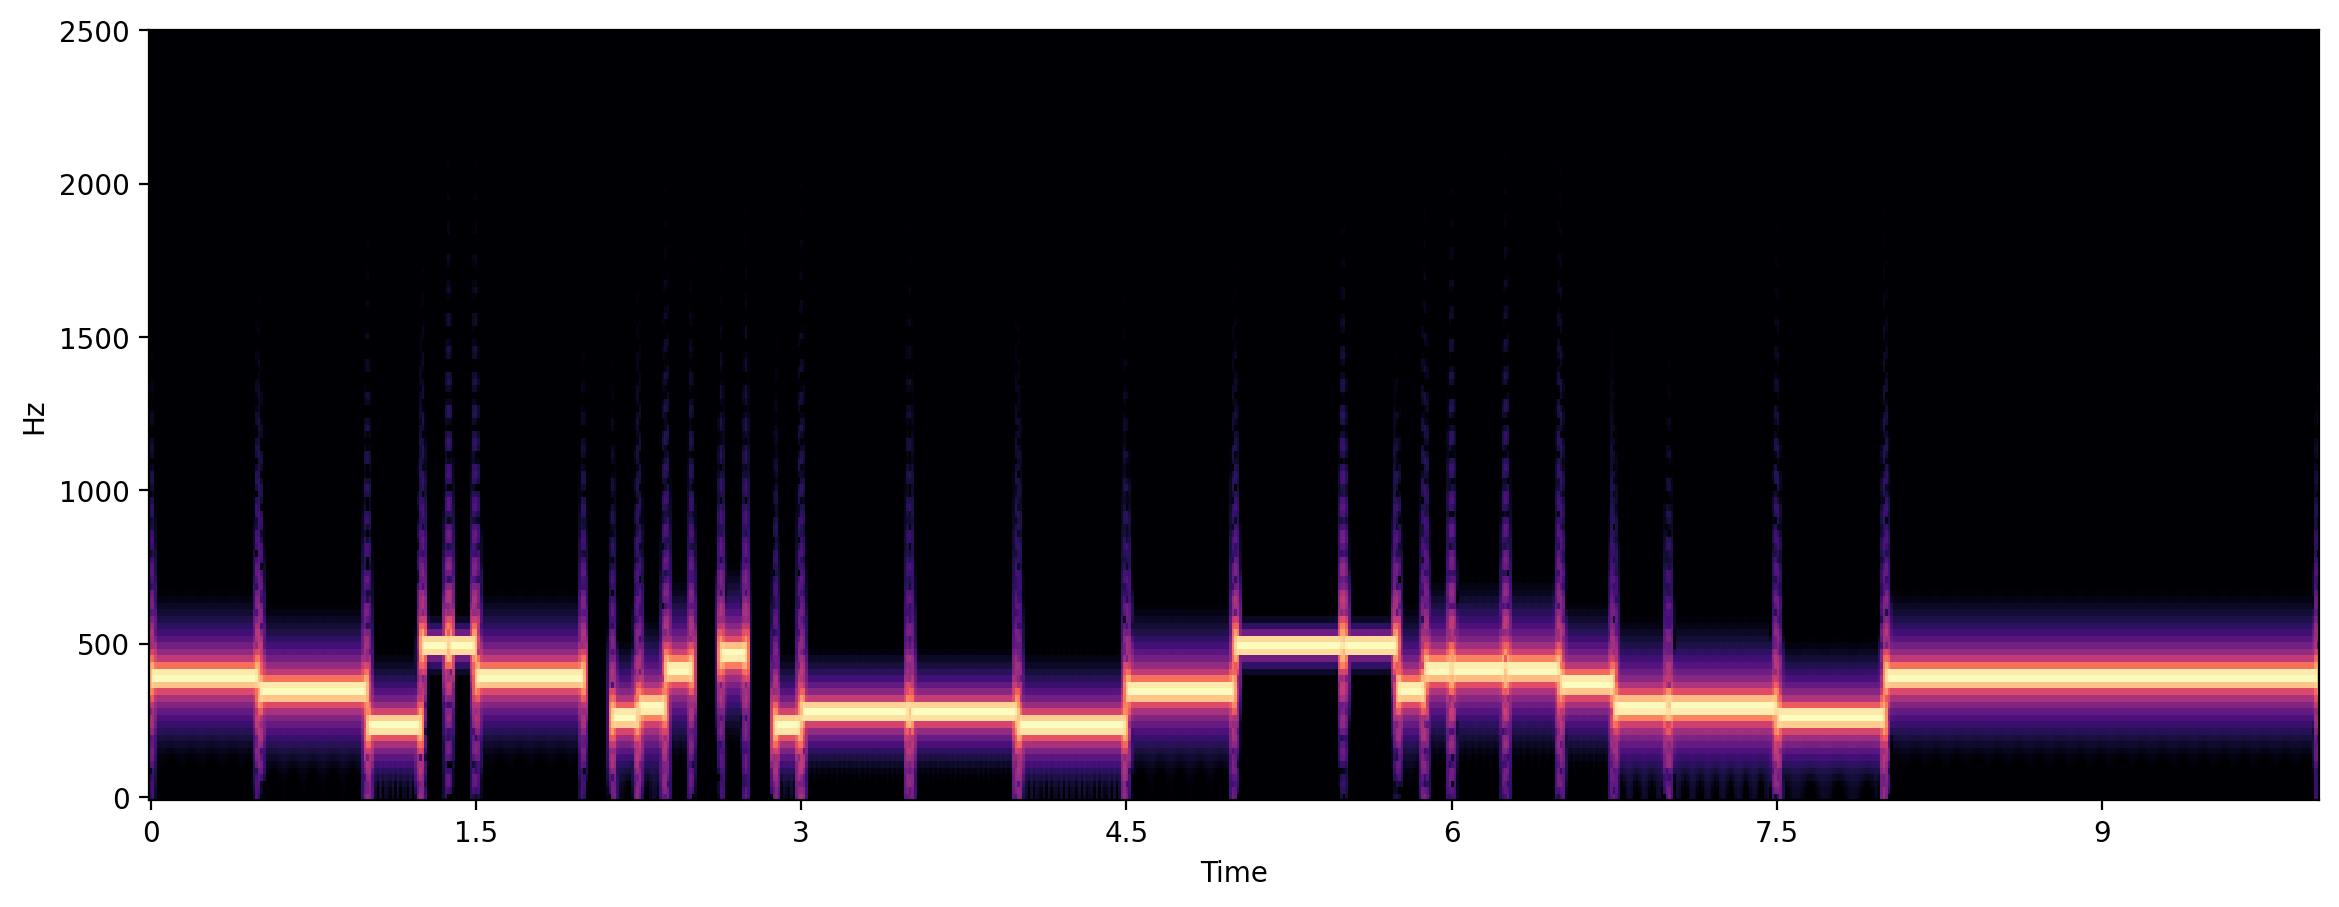

In [20]:
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
melody = np.random.randint(58, 72, 50)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
rhythm = get_rhythm(4)
rhythm_and_melody(rhythm, melody)

## More possibilities...

The Tonnetz melody does sound "less random" than the actual random melody. But it still does not sound like a "proper" melody. There are several reasons for this, the main one being that the Tonnetz generates harmonically related pitch classes that do not always result in nice melodic lines. There are several directions to further experiment and improve the generation:
- The melodies can be elaborated, for instance, by repeating notes (e.g. sampling additional notes from the last *k* notes in the original sequence), adding ornamentations (such as trills or neighbour notes), or by filling larger jumps with intermediate notes to generate smoother melodic lines.
- Instead of using the pitch-based version of the Tonnetz, one can use the triad based version with 5 possible steps corresponding to moving up/down on the line/circle of fifths and the three Neo-Riemannian transformations. Pitches can then be sampled from the respective triads (hint: good melodic lines emphasise the *changing* notes in the chord).
- For a given chord, the corresponding scale can be used to generate additional notes and filling patterns (as above but better matching the current harmony).